# Data logger, signal analisys and Digital filter design
## Data logger with pyserial
connect to the data logger to meassure a PT100 temperature transductor.

In [33]:
import pandas as pd
import numpy as np
import serial
import matplotlib.pyplot as plt
from scipy.fft import rfft,rfftfreq
from datetime import timedelta

conect arduino to usb port thenb open serial port (Argduino Mega Data logger ).

In [29]:
ser = serial.Serial('/dev/ttyUSB0',19200, timeout=2)

set sample frecuency, Period to log and number os samples

In [102]:
fs = 10 #(HZ) sample frecuency
Period = 240 #(s) to sample 
n = int( Period*fs ) #number of samples
## Adc Temperature resolution.
betaTemp = (20.5/0.315)*(5/2**10)

Pandas Series with time stamps

In [19]:
dt = timedelta( milliseconds=int( 1000/fs ) ) # minimum division of time is 1 ms.
data = pd.Series( np.zeros(n),index=[ i*dt for i in range(n)],name='Temperature' )
data.index.name = 'time'

Make data request to the board

In [30]:
## create storage object
t = pd.Series( np.arange( n )*int( 1000/fs )/1000,name='time' )
data = pd.Series( np.zeros(n),index=t,name='Temperature' )
##send the capture request (start byte, number of samples
ser.write( b'k'+ n.to_bytes(2,'big')+int( 1000/fs ).to_bytes(2,'big') )
for dt in t: data[dt] = betaTemp*int.from_bytes(ser.read(2), "big", signed=False) 
data.head()

time
0 days 00:00:00           19.383991
0 days 00:00:00.100000    19.383991
0 days 00:00:00.200000    19.383991
0 days 00:00:00.300000    19.383991
0 days 00:00:00.400000    19.383991
Name: Temperature, dtype: float64

plot the data

save data and/or close

In [37]:
#data.to_csv('TempData.csv')
ser.close()

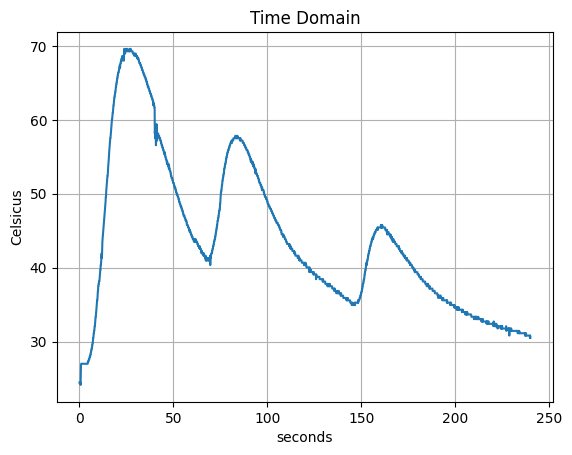

In [130]:
     ## load previuos data (uncomment next line)
#data = pd.read_csv('TempData.csv').set_index('time').iloc[:,0]

data.plot()
plt.ylabel('celsius')
plt.xlabel('seconds')
plt.title('Time Domain')
plt.grid()

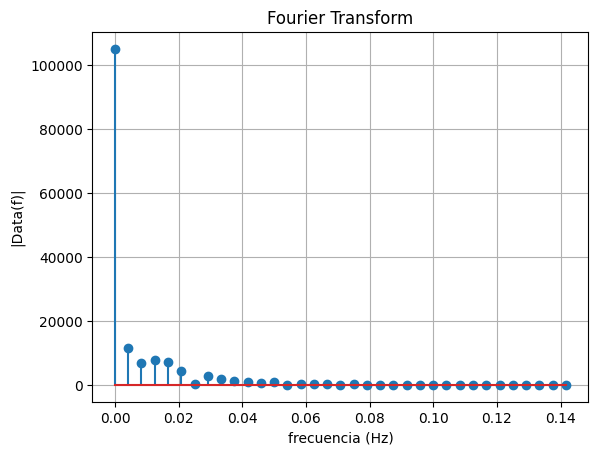

In [69]:
##Fourier Transform
r = 35
Data =  rfft( data.values ) 
H =abs( Data )
frecuencies = rfftfreq(data.size,1/fs)
plt.stem(frecuencies[:r] , H[:r]  )
plt.ylabel('|Data(f)|')
plt.xlabel('frecuencia (Hz)')
plt.title('Fourier Transform')
plt.grid()

## Discretization of a third order Butterworth low pass filter
With transfer funtion:

In [103]:
from sympy import *
ωc,T,s,z,f = symbols('ω_{c} T s z f')
H = ωc**3/( (s+ωc)*(s**2+ωc*s+ωc**2) )
H

ω_{c}**3/((s + ω_{c})*(s**2 + s*ω_{c} + ω_{c}**2))

Using a ZOH and the z-transform we obtain the transfer function in discrete time
$$
\begin{align}
H(z) = \frac{z-1}{z}\zeta\bigg\{\frac{ω_{c}³}{(s+ω_{c})(s²+ω_{c}s+ω_{c}²)}\bigg\}
\end{align}
$$
with the form
$$
\begin{align}
H(z) = \frac{a_{1}z^{-1}+a_{2}z^{-2}+a_{3}z^{-3}}{1+b_{1}z^{-1}+b_{2}z^{-2}+b_{3}z^{-3}}
\end{align}
$$

In [138]:
a = exp(-ωc*T/2)
b = sin( ωc*T*sqrt(3)/2 )
c = cos( ωc*T*sqrt(3)/2 )
##z Transform
Hz = collect(ratsimp(  ( (z-1)/z )*( z/(z-1) - z/(z-a**2) - 
                  (2/sqrt(3))*z*a*b/(z**2-2*z*a*c+a**2) )) ,z)
a0 = Poly( Hz.as_numer_denom()[1],z ).coeffs()[0]
numer = collect( expand( simplify( Hz.as_numer_denom()[0]/a0 ) )  ,z )
denom = collect( expand( simplify( Hz.as_numer_denom()[1]/a0 ) )  ,z )
numCoefs = Poly( numer,z ).coeffs()
denomCoefs = Poly( denom,z ).coeffs()
Hz = numer/denom
Hz

(z**2*(-2*sqrt(3)*exp(-3*T*ω_{c})*exp(T*ω_{c})**(5/2)*sin(sqrt(3)*T*ω_{c}/2)/3 + 1 - exp(-T*ω_{c})) + z*(-4*sqrt(3)*exp(-2*T*ω_{c})*exp(T*ω_{c})**(3/2)*cos(sqrt(3)*T*ω_{c}/2 + pi/6)/3 + 4*sqrt(3)*exp(-3*T*ω_{c})*exp(T*ω_{c})**(3/2)*sin(sqrt(3)*T*ω_{c}/2 + pi/3)/3) + exp(-T*ω_{c}) - exp(-2*T*ω_{c}) - 2*sqrt(3)*exp(-3*T*ω_{c}/2)*sin(sqrt(3)*T*ω_{c}/2)/3)/(z**3 + z**2*(-2*exp(-3*T*ω_{c})*exp(T*ω_{c})**(5/2)*cos(sqrt(3)*T*ω_{c}/2) - exp(-T*ω_{c})) + z*(2*exp(-3*T*ω_{c})*exp(T*ω_{c})**(3/2)*cos(sqrt(3)*T*ω_{c}/2) + exp(-T*ω_{c})) - exp(-2*T*ω_{c}))

We choose the cutoff frequency $f_{c}$ and change to the frecuency domain by substituting
$
\begin{align}
z = e^{2i\pi fT}
\end{align}
$
then plot the bode diagram

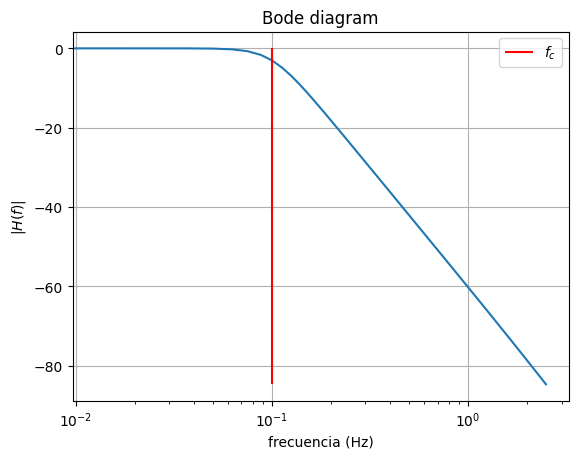

In [142]:
fc = 0.1 #Hz cutoff frequency
wc = 2*np.pi*fc
Ts = data.index[1]
Hf = Abs( Hz.subs({'z':exp(2j*np.pi*f*T)}) )
Filter = np.vectorize( lambdify(f, Abs( N( Hf.subs({'ω_{c}':wc,'T':Ts}) ) ),modules=['numpy']) )
frecuencies = np.linspace(0,fs/4,200)
FrecuencyResponse = 20*np.log10( Filter(frecuencies) )

plt.plot(frecuencies,FrecuencyResponse)
plt.vlines(wc/(2*np.pi),FrecuencyResponse.min(),FrecuencyResponse.max(),colors='r',
           label='$f_{c}$')
plt.xscale('log') 
plt.ylabel('$|H(f)|$')
plt.xlabel('frecuencia (Hz)')
plt.title('Bode diagram')
plt.grid()
plt.legend()

To get the discrete difference equation for filtering in real time we need the coeficients $a_{i}$ and $b_{i}$

In [143]:
a =  lambda omega,period: np.array( lambdify(  [ωc,T], numCoefs )(omega,period) )
b =  lambda omega,period: np.array( lambdify(  [ωc,T], denomCoefs[1:] )(omega,period) )

## Simulation of the filter given the data and the discrete difference equation
$$ y(n) = a_{1}x(n-1)+a_{2}x(n-2)+a_{3}x(n-3)-[b_{1}y(n-1)+b_{2}y(n-2)+b_{3}y(n-3)  ]$$ 

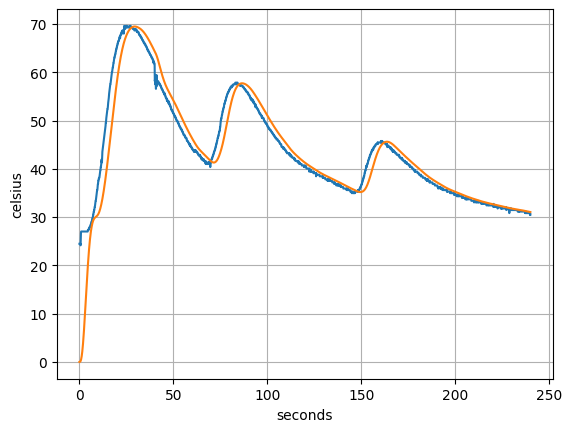

In [149]:
x = np.zeros(4)
y = np.zeros(4)
A = a(wc,Ts)
B = b(wc,Ts)

FilteredData = pd.Series(np.zeros(data.size),index=data.index)
for i in range(data.size):
    x[0] = data.values[i]
    y[0] = A@x[1:]-B@y[1:]
    x[1:] = x[:-1]
    y[1:] = y[:-1]
    FilteredData.iloc[i] = y[0]
    
plt.plot(data)
plt.plot(dataFil)
plt.ylabel('celsius')
plt.xlabel('seconds')
plt.grid()